# 320to335 (15-30 November)

In [1]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
from matplotlib import rcParams
import shap
from sklearn.linear_model import LinearRegression
from sklearn import metrics
import seaborn as sns

from catboost import Pool, CatBoostRegressor, cv 
from catboost.utils import eval_metric

# Data

In [2]:
df = pd.read_stata('T:\\COVID19\\Makrodaten\\Nov15-30woP.dta')


One or more strings in the dta file could not be decoded using utf-8, and
so the fallback encoding of latin-1 is being used.  This can happen when a file
has been incorrectly encoded by Stata or some other software. You should verify
the string values returned are correct.


In [3]:
Y = df['std_inz_AGS_320to335']
X = df.loc[:, ~df.columns.isin(['std_inz_AGS_320to335'])]
f_names = list(X.columns)
print("Number of features: ", len(X.columns))

Number of features:  155


# First CatBoost Model with 969 features

In [4]:
# initialize Pool
train_pool = Pool(X,Y)
 

# specify the training parameters 
model = CatBoostRegressor(random_seed=0, logging_level = 'Silent')
#train the model
cb = model.fit(train_pool)
print("R2 of final model on all data: ",cb.score(X, Y))

R2 of final model on all data:  0.9994235570304045


In [5]:
preds = cb.predict(train_pool,
                    prediction_type="RawFormulaVal"
                  )

print("RMSE of final model on all data: ", eval_metric(Y, preds, 'RMSE')[0])

RMSE of final model on all data:  3.458946804417844


# SHAP VAlues

In [6]:
shap_values_cb = shap.TreeExplainer(cb).shap_values(X)

invalid value encountered in true_divide
invalid value encountered in true_divide


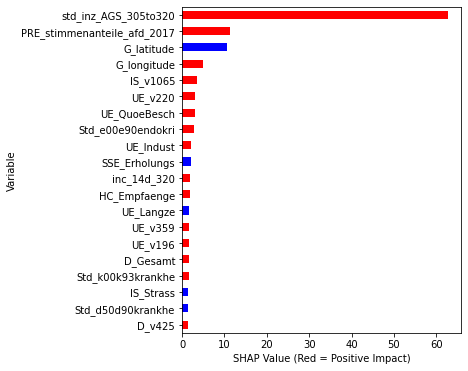

In [7]:
def ABS_SHAP(df_shap,df):
    # Make a copy of the input data
    shap_v = pd.DataFrame(df_shap)
    feature_list = df.columns
    shap_v.columns = feature_list
    df_v = df.copy().reset_index().drop('index',axis=1)
    
    # Determine the correlation in order to plot with different colors
    corr_list = list()
    for i in feature_list:
        b = np.corrcoef(shap_v[i],df_v[i])[1][0]
        corr_list.append(b)
    corr_df = pd.concat([pd.Series(feature_list),pd.Series(corr_list)],axis=1).fillna(0)
    # Make a data frame. Column 1 is the feature, and Column 2 is the correlation coefficient
    corr_df.columns  = ['Variable','Corr']
    corr_df['Sign'] = np.where(corr_df['Corr']>0,'red','blue')
    
    # Plot it
    shap_abs = np.abs(shap_v)
    k=pd.DataFrame(shap_abs.mean()).reset_index()
    k.columns = ['Variable','SHAP_abs']
    k2 = k.merge(corr_df,left_on = 'Variable',right_on='Variable',how='inner')
    k2 = k2.sort_values(by='SHAP_abs',ascending = True)[-20::]
    colorlist = k2['Sign']
    ax = k2.plot.barh(x='Variable',y='SHAP_abs',color = colorlist, figsize=(5,6),legend=False)
    ax.set_xlabel("SHAP Value (Red = Positive Impact)")
    
ABS_SHAP(shap_values_cb,X) 

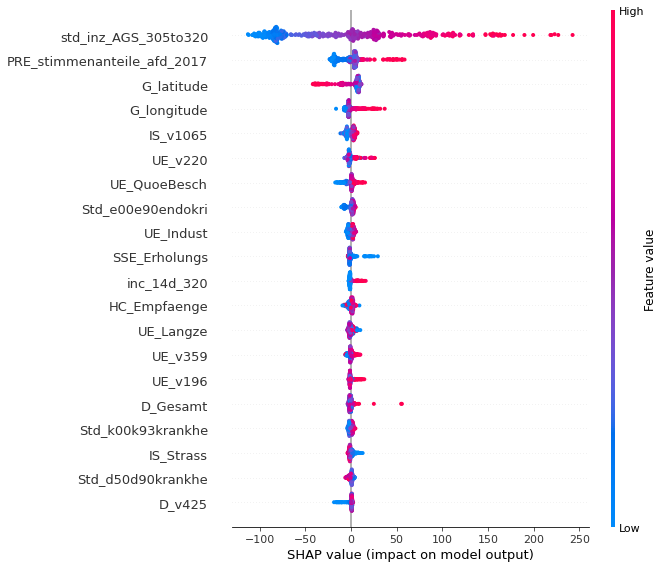

In [8]:
shap.summary_plot(shap_values_cb,X)

# Second CatBoost model with 20 most important features

In [9]:
top20feature = X.columns[np.argsort(np.abs(shap_values_cb).mean(0))][-20:][::-1]
top10feature = X.columns[np.argsort(np.abs(shap_values_cb).mean(0))][-10:][::-1]

In [10]:
# initialize Pool
train_pool_20 = Pool(X[top20feature],Y)
 

# specify the training parameters 
model = CatBoostRegressor(random_seed=0, logging_level = 'Silent')
#train the model
cb_20 = model.fit(train_pool_20)
print("R2 of second model with top20 feature: ",cb_20.score(X[top20feature], Y))

R2 of second model with top20 feature:  0.9971689186514832


In [11]:
preds_20 = cb_20.predict(train_pool_20,
                    prediction_type="RawFormulaVal"
                  )

print("RMSE of second model on top20 data: ", eval_metric(Y, preds_20, 'RMSE')[0])

RMSE of second model on top20 data:  7.665524638454845


# Compare top 10 features of both Models

In [12]:
shap_values_cb_20 = shap.TreeExplainer(cb_20).shap_values(X[top20feature])

top10feature_from_top_20 = X[top20feature].columns[np.argsort(np.abs(shap_values_cb_20).mean(0))][-10:][::-1]

print("10 most important features from model with all features:", "\n", list(top10feature), "\n\n",
     "10 most important features from model with top20 features:", "\n", list(top10feature_from_top_20)) 

10 most important features from model with all features: 
 ['std_inz_AGS_305to320', 'PRE_stimmenanteile_afd_2017', 'G_latitude', 'G_longitude', 'IS_v1065', 'UE_v220', 'UE_QuoeBesch', 'Std_e00e90endokri', 'UE_Indust', 'SSE_Erholungs'] 

 10 most important features from model with top20 features: 
 ['std_inz_AGS_305to320', 'G_latitude', 'PRE_stimmenanteile_afd_2017', 'G_longitude', 'UE_v196', 'UE_v220', 'SSE_Erholungs', 'UE_QuoeBesch', 'Std_e00e90endokri', 'UE_Indust']


In [13]:
# features which are on top10 of both models:
for i in top10feature :
    if i in list(top10feature_from_top_20) :
         print(i)

std_inz_AGS_305to320
PRE_stimmenanteile_afd_2017
G_latitude
G_longitude
UE_v220
UE_QuoeBesch
Std_e00e90endokri
UE_Indust
SSE_Erholungs


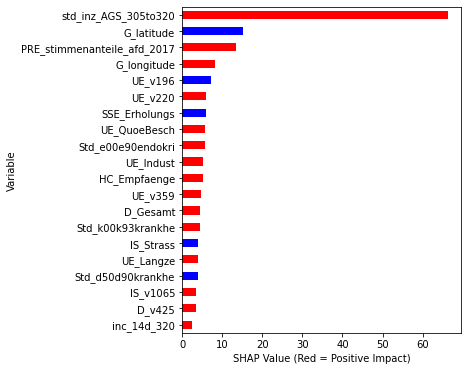

In [14]:
ABS_SHAP(shap_values_cb_20,X[top20feature]) 

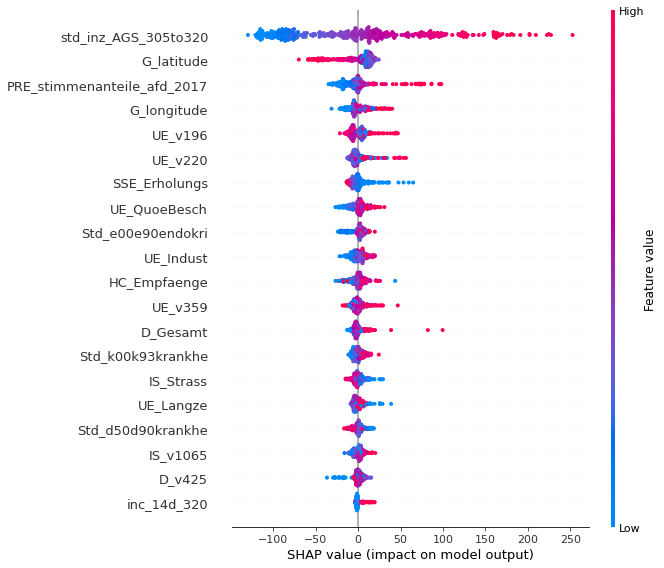

In [15]:
shap.summary_plot(shap_values_cb_20,X[top20feature])

# Hold out validation of the second model

In [16]:
import random
iterations = range(0,20)

r2_reg_k_test_top20 = list(range(0,20))
rmse_reg_k_test_top20 = list(range(0,20))
r2_cb_k_train_top20 = list(range(0,20))
r2_cb_k_test_top20 = list(range(0,20))

for i in iterations:
    rs = random.sample(range(0,401), 80)
    k_test_x = X[top20feature].iloc[rs]
    k_test_y = Y.iloc[rs]
    k_train_x = X[top20feature].drop(rs)
    k_train_y = Y.drop(rs)
    # initialize Pool 
    train_pool_k = Pool(data=k_train_x,
                        label=k_train_y,
                        feature_names = list(X[top20feature].columns))
        
    test_pool_k = Pool(data=k_test_x,
                       label=k_test_y,
                       feature_names = list(X[top20feature].columns))

    
    #fit the model
    model = CatBoostRegressor(random_seed=0,
                              logging_level="Silent",
                              #iterations = scores_k.sort_values(by= "test-R2-mean")["iterations"].iloc[-1]
                             )

    cb_k = model.fit(train_pool_k)
    
    # make the prediction using the resulting model
    preds_k = cb_k.predict(test_pool_k,
                    prediction_type="RawFormulaVal"
                  )
    
    rmse_reg_k_test_top20[i] = eval_metric(np.array(k_test_y), preds_k, "RMSE")[0]
    
    preds_k = preds_k.reshape(-1, 1)
    #LinearRegression
    reg_k = LinearRegression().fit(preds_k, k_test_y)

    
    r2_cb_k_train_top20[i] = cb_k.score(train_pool_k)
    r2_reg_k_test_top20[i] = reg_k.score(preds_k, k_test_y)

    r2_cb_k_test_top20[i] =  cb_k.score(test_pool_k)
    
    print(i/len(iterations)*100,"%", "  " , end="")

0.0 %   5.0 %   10.0 %   15.0 %   20.0 %   25.0 %   30.0 %   35.0 %   40.0 %   45.0 %   50.0 %   55.00000000000001 %   60.0 %   65.0 %   70.0 %   75.0 %   80.0 %   85.0 %   90.0 %   95.0 %   

In [17]:
print("Mean R2 of CatBoost_models on train sets with top20 features:",sum(r2_cb_k_train_top20)/len(r2_cb_k_train_top20))
print("Mean R2 of linReg_modesl with top20 features: ", sum(r2_reg_k_test_top20)/len(r2_reg_k_test_top20))
print("Mean RMSE of CatBoost_models on test sets with top20 features: ", sum(rmse_reg_k_test_top20)/len(rmse_reg_k_test_top20))
print("Mean R2 of CatBoost_models on test sets with top20 features:",sum(r2_cb_k_test_top20)/len(r2_cb_k_test_top20))

Mean R2 of CatBoost_models on train sets with top20 features: 0.998419836835007
Mean R2 of linReg_modesl with top20 features:  0.6931411671457357
Mean RMSE of CatBoost_models on test sets with top20 features:  83.21255816720972
Mean R2 of CatBoost_models on test sets with top20 features: 0.6789425935379613


# descriptives of top20 features

In [18]:
X[top20feature].describe()

,std_inz_AGS_305to320,PRE_stimmenanteile_afd_2017,G_latitude,G_longitude,IS_v1065,UE_v220,UE_QuoeBesch,Std_e00e90endokri,UE_Indust,SSE_Erholungs,inc_14d_320,HC_Empfaenge,UE_Langze,UE_v359,UE_v196,D_Gesamt,Std_k00k93krankhe,IS_Strass,Std_d50d90krankhe,D_v425
count,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000
mean,294.754181,13.388280,50.615307,9.866997,21.925186,34.556614,49.557602,64.049629,18.253864,70.509460,201.515823,50.857349,32.202728,68.926453,66.924667,5.103244,235.603394,491.092896,15.433549,5.230676
std,132.152008,5.329521,1.740311,2.026269,15.378860,13.284161,5.944391,15.094089,8.723560,56.734703,400.715698,6.518342,8.077897,11.196053,6.630356,4.276378,47.166279,87.669556,3.926366,9.954544
min,51.452923,4.900000,47.500000,6.083333,0.000000,4.600000,29.600000,0.000000,0.000000,14.000000,0.000000,28.600000,10.500000,27.500000,44.299999,-14.000000,0.000000,275.799988,0.000000,-32.299999
25%,187.580597,9.800000,49.283333,8.216666,13.000000,26.100000,45.700001,54.863358,12.700000,39.700001,0.000000,46.400002,25.600000,62.099998,62.700001,2.500000,211.117508,431.399994,13.190176,-0.700000
50%,295.148651,12.000000,50.549999,9.766666,21.000000,32.000000,49.900002,63.261333,17.200001,52.799999,0.000000,51.099998,32.700001,70.000000,67.599998,5.100000,238.374100,476.399994,15.132677,5.100000
75%,375.239899,15.300000,51.849998,11.416667,32.000000,41.400002,53.599998,72.358131,22.700001,76.699997,0.000000,55.599998,38.500000,76.699997,71.300003,7.500000,261.783997,545.000000,17.398548,11.300000
max,734.390442,35.500000,54.783333,14.983334,79.000000,101.000000,66.400002,112.477448,91.800003,384.600006,1302.830811,66.699997,53.400002,95.099998,81.599998,21.299999,359.559631,803.599976,28.615879,35.700001


In [19]:
pd.DataFrame(Y).describe()

,std_inz_AGS_320to335
count,401.000000
mean,299.439178
std,144.247375
min,20.302881
25%,203.504822
50%,286.181732
75%,371.910645
max,968.592468


In [ ]:
frames = [ Y.describe(), X[top20feature].describe()]
des = pd.concat(frames, axis=1)
with pd.ExcelWriter(r"C:\Users\Constantin\Desktop\descriptives1.xlsx") as writer:  
    des.to_excel(writer, sheet_name='period 1')